In [69]:
import pandas as pd
import numpy as np

projection_sscore_path  = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_agp3k/wgs/work/ba/536383e6f25e9436db0018e29127bd/cteph_agp3k.bbj.projection.sscore"
projection_sscore = pd.read_csv(projection_sscore_path, sep="\t", header=0)
# projection_sscore.head()

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

plt.style.use('default')

def plot_pca_with_kde_and_rectangle(projection_sscore, rect_xlim, rect_ylim, output_path="CTEPH_AGP3K.bbj_projection.png"):
    # 设置颜色和标签映射函数
    def get_color(iid):
        if iid.startswith('PHOM'):
            return '#E64B35'  # 红色
        elif iid.startswith('bbj'):
            return '#C0C0C0'  # 浅灰
        else:
            return '#4DBBD5'  # 蓝绿

    def get_label(iid):
        if iid.startswith('PHOM'):
            return 'CTEPH'
        elif iid.startswith('bbj'):
            return 'BBJ'
        else:
            return 'AGP3K'

    # 添加颜色和分组标签
    projection_sscore['Color'] = projection_sscore['IID'].apply(get_color)
    projection_sscore['Group'] = projection_sscore['IID'].apply(get_label)

    # 设置样式
    plt.style.use('default')
    sns.set_theme(style="whitegrid", context="talk", font_scale=1.2)

    # 图布局
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                           wspace=0.05, hspace=0.05)

    ax_main = plt.subplot(gs[1, 0])
    ax_top = plt.subplot(gs[0, 0], sharex=ax_main)
    ax_right = plt.subplot(gs[1, 1], sharey=ax_main)

    # 主散点图
    ax_main.scatter(
        projection_sscore['PC1_AVG'],
        projection_sscore['PC2_AVG'],
        c=projection_sscore['Color'],
        s=8,
        alpha=0.75,
        linewidth=0
    )

    ax_main.set_xlabel("PC1_AVG", fontsize=14)
    ax_main.set_ylabel("PC2_AVG", fontsize=14)
    ax_main.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

    # 图例
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='CTEPH', markerfacecolor='#E64B35', markersize=6),
        Line2D([0], [0], marker='o', color='w', label='AGP3K', markerfacecolor='#4DBBD5', markersize=6),
        Line2D([0], [0], marker='o', color='w', label='BBJ', markerfacecolor='#C0C0C0', markersize=6)
    ]
    ax_main.legend(handles=legend_elements, loc='upper left', frameon=False, fontsize=11)

    ax_top.tick_params(bottom=False, labelbottom=False)
    ax_right.tick_params(left=False, labelleft=False)

    # KDE 图：仅 CTEPH 和 AGP3K
    for color, label in [('#E64B35', 'CTEPH'), ('#4DBBD5', 'AGP3K')]:
        subset = projection_sscore[projection_sscore['Group'] == label]
        sns.kdeplot(x=subset['PC1_AVG'], ax=ax_top, color=color, fill=True, linewidth=1, alpha=0.5)
        sns.kdeplot(y=subset['PC2_AVG'], ax=ax_right, color=color, fill=True, linewidth=1, alpha=0.5)

    ax_top.set_ylabel('')
    ax_top.set_yticks([])
    ax_top.set_yticklabels([])
    ax_right.set_xlabel('')
    ax_right.set_xticks([])
    ax_right.set_xticklabels([])

    # 添加矩形框
    rect = Rectangle(
        (rect_xlim[0], rect_ylim[0]),
        rect_xlim[1] - rect_xlim[0],
        rect_ylim[1] - rect_ylim[0],
        linewidth=1.5, edgecolor='black', facecolor='none', linestyle='--'
    )
    ax_main.add_patch(rect)

    # 筛选落在矩形内的 CTEPH 和 AGP3K 样本
    mask = (
        (projection_sscore['PC1_AVG'] >= rect_xlim[0]) &
        (projection_sscore['PC1_AVG'] <= rect_xlim[1]) &
        (projection_sscore['PC2_AVG'] >= rect_ylim[0]) &
        (projection_sscore['PC2_AVG'] <= rect_ylim[1])
    )
    selected = projection_sscore.loc[
        mask & projection_sscore['Group'].isin(['CTEPH', 'AGP3K']),
        ['IID', 'Group']
    ]
    subset_ids = selected['IID'].values

    # 数量注释
    group_counts = selected['Group'].value_counts().to_dict()
    n_cteph = group_counts.get('CTEPH', 0)
    n_agp3k = group_counts.get('AGP3K', 0)

    text_str = f"CTEPH: n={n_cteph}\nAGP3K: n={n_agp3k}"
    ax_main.text(
        0.70, 0.02, text_str,
        transform=ax_main.transAxes,
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='white', alpha=0.7)
    )

    plt.suptitle("CTEPH + AGP3K based on BBJ Projection", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

    return subset_ids

/tmp/ipykernel_377585/3747843687.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])


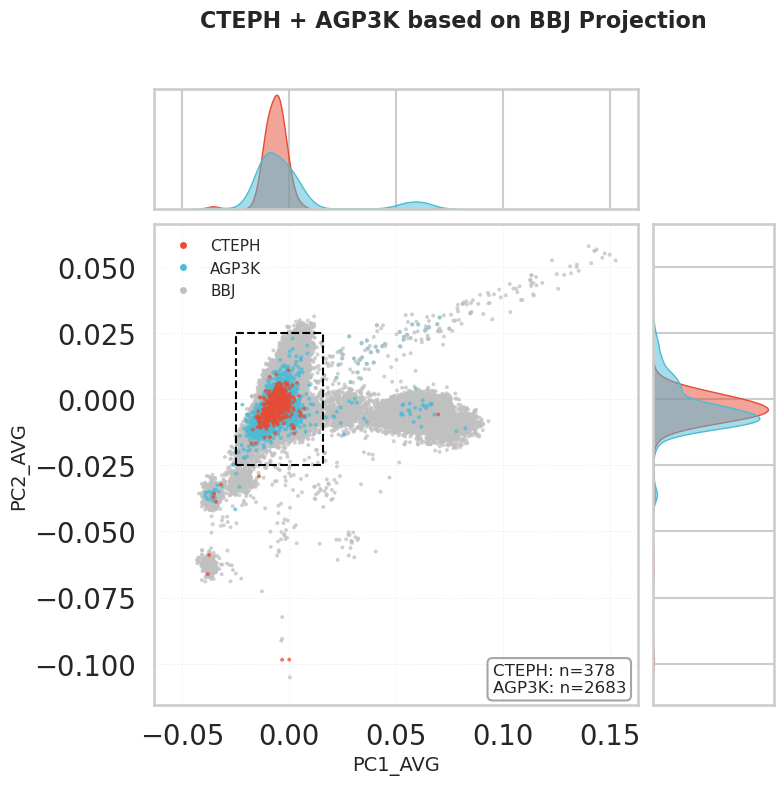

In [71]:
subset_ids = plot_pca_with_kde_and_rectangle(
    projection_sscore=projection_sscore,
    rect_xlim=(-0.025, 0.016),
    rect_ylim=(-0.025, 0.025)
)

In [68]:
df_subset = pd.DataFrame({'#FID': subset_ids.astype(str), 'IID': subset_ids.astype(str)})
df_subset.to_csv(
    "CTEPH_AGP3K.bbj_projection.subset.txt",
    sep="\t",
    index=False,
    header=True
)